In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [4]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [5]:
symbols = trainSet.ticker.unique()

In [6]:
timesteps = 60
def make_samples(
    data_1,
    data_2,
    data3,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps: i, 0]
        x_3 = data_3[i-timesteps: i, 0]
        x_1 = x_1.reshape(-1,1)
        x_2 = x_2.reshape(-1,1)
        x_3 = x_3.reshape(-1,1)
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    sc.partial_fit(x_2)
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['x_2'][j].append(sc.transform(x_2))
                    train_set[s]['y'][j].append(sc.transform(y))
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    train_set[s]['x_3'][j].append(sc.fit_transform(x_3))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [7]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
t = 1
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'x_2':{},
        'x_3':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['x_2'][i] = []
        train_set[s]['x_3'][i] = []
        train_set[s]['y'][i] = []
        
    mv_rate = 20
    df = trainSet.loc[trainSet['ticker'] == s][['adj_close']]
    data_1 = df.values
    data_1 = data_1[mv_rate -1:]
    
    data_2 = df.rolling(mv_rate).mean().values
    data_2 = data_2[mv_rate-1:]
    
    df = trainSet.loc[trainSet['ticker'] == s][['volume']]
    data_3 = df.values
    data_3 = data_3[mv_rate -1:]
 
    make_samples(
        data_1,
        data_2,
        data_3,
        s)
    if t == 200:
        break
    t += 1

In [8]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [9]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(3,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [31]:
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
                train_set[s]['x_2'][i][j],
                train_set[s]['x_3'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(115150, 3, 60) (115150,)
Fitting prediction interval 1  model
Train on 80605 samples, validate on 34545 samples
Epoch 1/100
80605/80605 [==============================] - 7s 88us/step - loss: 0.1894 - val_loss: 0.0973
Epoch 2/100
80605/80605 [==============================] - 1s 17us/step - loss: 0.1202 - val_loss: 0.0754
Epoch 3/100
80605/80605 [==============================] - 1s 16us/step - loss: 0.0912 - val_loss: 0.0667
Epoch 4/100
80605/80605 [==============================] - 1s 15us/step - loss: 0.0757 - val_loss: 0.0598
Epoch 5/100
80605/80605 [==============================] - 1s 15us/step - loss: 0.0648 - val_loss: 0.0566
Epoch 6/100
80605/80605 [==============================] - 1s 15us/step - loss: 0.0598 - val_loss: 0.0453
Epoch 7/100
80605/80605 [==============================] - 1s 16us/step - loss: 0.0544 - val_loss: 0.0423
Epoch 8/100
80605/80605 [==============================] - 1s 16us/step - loss: 0.0504 - val_loss: 0.0386
Epoch 9/100
80605/80605 [==============

80055/80055 [==============================] - 1s 16us/step - loss: 0.0598 - val_loss: 0.0500
Epoch 18/100
80055/80055 [==============================] - 1s 16us/step - loss: 0.0599 - val_loss: 0.0493
Epoch 19/100
80055/80055 [==============================] - 1s 15us/step - loss: 0.0589 - val_loss: 0.0489
Epoch 20/100
80055/80055 [==============================] - 1s 16us/step - loss: 0.0579 - val_loss: 0.0490
Epoch 21/100
80055/80055 [==============================] - 1s 16us/step - loss: 0.0573 - val_loss: 0.0471
Epoch 22/100
80055/80055 [==============================] - 1s 15us/step - loss: 0.0574 - val_loss: 0.0479
Epoch 23/100
80055/80055 [==============================] - 1s 15us/step - loss: 0.0572 - val_loss: 0.0472
Epoch 24/100
80055/80055 [==============================] - 1s 15us/step - loss: 0.0565 - val_loss: 0.0476
Epoch 25/100
80055/80055 [==============================] - 1s 15us/step - loss: 0.0558 - val_loss: 0.0496
Epoch 26/100
80055/80055 [========================

## Loss graph

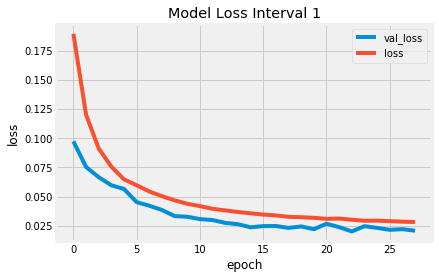

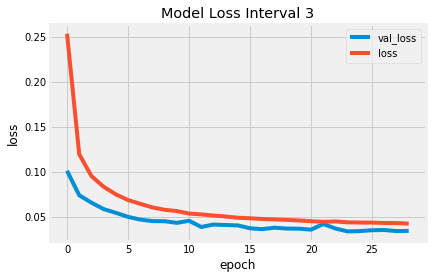

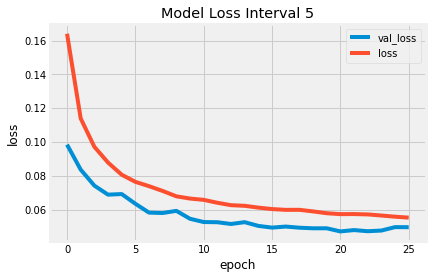

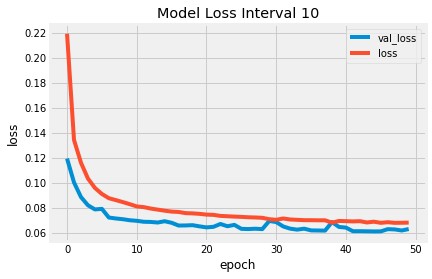

In [32]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['val_loss'])
    plt.plot(model_history[i].history['loss'])
    plt.title('Model Loss Interval {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.show()

## Helper functions

In [33]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [34]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Predict with Test Set

In [35]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'x_2':{},
            'x_3':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['x_2'][i] = []
            test_set[s]['x_3'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    df = testSet.loc[testSet['ticker'] == s][['adj_close']]
    mv_rate = 20
    data_1 = df.values
    data_1 = data_1[mv_rate -1:]
    
    data_2 = df.rolling(mv_rate).mean().values
    data_2 = data_2[mv_rate-1:]
    
    df = testSet.loc[testSet['ticker'] == s][['volume']]
    data_3 = df.values
    data_3 = data_3[mv_rate -1:]
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps: i, 0]
        x_3 = data_3[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    x_2 = x_2.reshape(-1,1)
                    x_3 = x_3.reshape(-1,1)

                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(x_2)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['x_2'][j].append(sc.transform(x_2))
                    test_set[s]['y'][j].append(y)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    test_set[s]['x_3'][j].append(sc.fit_transform(x_3))
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [36]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
                data[s]['x_2'][i][j],
                data[s]['x_3'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

## Predicting sample

In [37]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 23.659264007948305
Test Set -> MSE of AAPL inveral 3: 27.63080395790204
Test Set -> MSE of AAPL inveral 5: 43.970827558167684
Test Set -> MSE of AAPL inveral 10: 70.41563863334238


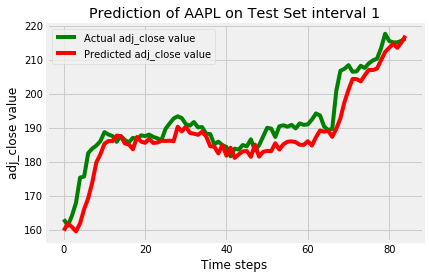

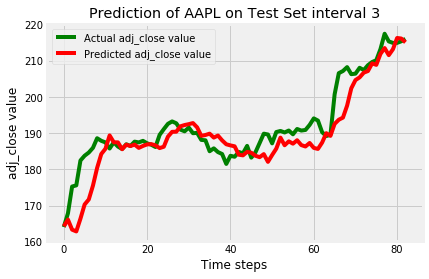

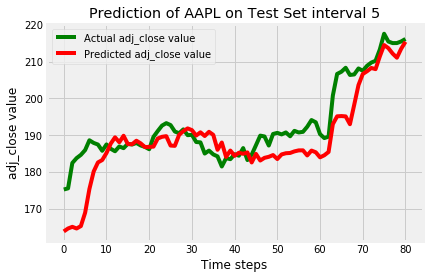

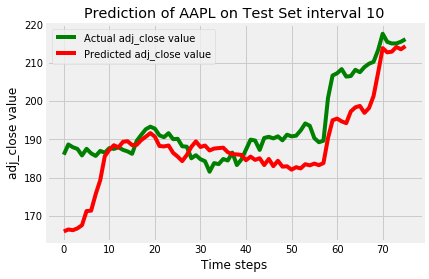

In [38]:
for i in prediction_intervals:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 5 symbols

In [39]:
test_symbols = ['A','ACER','MSFT','ABC','AAPL']

In [40]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [41]:
all_mse_1 = []
all_mse_3 = []
all_mse_5 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 2))
    all_mse_3.append(round(all_mse[s][3], 2))
    all_mse_5.append(round(all_mse[s][5], 2))
    all_mse_10.append(round(all_mse[s][10], 2))

In [42]:
all_mse_1

[1.36, 1.74, 3.11, 3.32, 23.66]

In [43]:
all_mse_3

[3.27, 3.29, 3.24, 7.88, 27.63]

In [44]:
all_mse_5

[3.7, 4.95, 4.28, 12.74, 43.97]

In [45]:
all_mse_10

[4.14, 5.65, 6.86, 19.71, 70.42]